# 🗂️ 쓰레기 분류 딥러닝 모델

이 노트북은 쓰레기 이미지를 6개 카테고리로 분류하는 딥러닝 모델을 구현합니다.

## 📊 데이터셋 정보
| 카테고리 | 설명 | 예시 |
|---------|------|------|
| cardboard | 골판지 | 📦 박스, 포장재 |
| glass | 유리 | 🍺 병, 유리컵 |
| metal | 금속 | 🥫 캔, 금속 용기 |
| paper | 종이 | 📄 문서, 신문 |
| plastic | 플라스틱 | 🥤 페트병, 플라스틱 용기 |
| trash | 기타 쓰레기 | 🗑️ 분류 불가 쓰레기 |

## 🔄 워크플로우
1. **환경 설정** - 라이브러리 import 및 경로 설정
2. **데이터 탐색** - 데이터셋 구조 파악
3. **데이터 전처리** - 이미지 resize 및 NPZ 변환
4. **데이터 로드** - 학습/테스트 데이터 분할
5. **모델 설계** - 신경망 구조 정의
6. **모델 학습** - 훈련 및 검증
7. **결과 분석** - 성능 평가 및 시각화


In [11]:
# 🔧 1. 환경 설정 및 라이브러리 Import

# 기본 라이브러리
import numpy as np 
import os 
import random 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# 이미지 처리
import PIL.Image as pilimg 
import imghdr

# 데이터 분석
import pandas as pd 

# 머신러닝/딥러닝
import tensorflow as tf 
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# 시각화 설정
plt.style.use('default')
sns.set_palette("husl")

print("✅ 라이브러리 import 완료!")
print(f"TensorFlow 버전: {tf.__version__}")
print(f"GPU 사용 가능: {tf.config.list_physical_devices('GPU') != []}")


✅ 라이브러리 import 완료!
TensorFlow 버전: 2.19.0
GPU 사용 가능: False


In [12]:
# 📁 경로 설정 및 전역 변수

# 데이터 경로 (절대경로로 변경)
base_path = r"C:/Users/ryan9/문서/GitHub/SeSac-AI-Developer-Notes-2025/07_Deep_Learning/data/Garbageclassification"
title = "thresh"

# 이미지 처리 설정
IMAGE_SIZE = (80, 80)  # 이미지 크기 통일
CHANNELS = 3  # RGB 채널
NUM_CLASSES = 6  # 분류할 클래스 수

# 클래스 이름 매핑
CLASS_NAMES = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
CLASS_LABELS = {i: name for i, name in enumerate(CLASS_NAMES)}

print("📁 경로 설정 완료:")
print(f"  데이터 경로: {base_path}")
print(f"  이미지 크기: {IMAGE_SIZE}")
print(f"  클래스 수: {NUM_CLASSES}")
print(f"  클래스: {CLASS_NAMES}")


📁 경로 설정 완료:
  데이터 경로: C:/Users/ryan9/문서/GitHub/SeSac-AI-Developer-Notes-2025/07_Deep_Learning/data/Garbageclassification
  이미지 크기: (80, 80)
  클래스 수: 6
  클래스: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [13]:
# 🔍 2. 데이터셋 탐색 및 구조 파악

def explore_dataset():
    """데이터셋의 구조와 정보를 탐색하는 함수"""
    
    print("🔍 데이터셋 구조 분석 중...")
    
    if not os.path.exists(base_path):
        print(f"❌ 데이터 경로를 찾을 수 없습니다: {base_path}")
        print("💡 상위 디렉토리에서 데이터 폴더를 확인해주세요.")
        return None
    
    # 카테고리별 폴더 확인
    categories = os.listdir(base_path)
    print(f"📂 발견된 카테고리: {len(categories)}개")
    
    # 각 카테고리별 이미지 수 확인
    category_info = []
    total_images = 0
    
    for idx, category in enumerate(categories):
        category_path = os.path.join(base_path, category)
        if os.path.isdir(category_path):
            image_files = [f for f in os.listdir(category_path) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png', '.gif'))]
            count = len(image_files)
            total_images += count
            
            category_info.append({
                'Index': idx,
                'Category': category,
                'Count': count,
                'Percentage': 0  # 나중에 계산
            })
            
            print(f"  {idx}: {category:10} - {count:4}개 이미지")
    
    # 비율 계산
    for info in category_info:
        info['Percentage'] = (info['Count'] / total_images) * 100
    
    print(f"\n📊 총 이미지 수: {total_images:,}개")
    print(f"📈 평균 카테고리당: {total_images // len(categories):,}개")
    
    return category_info

# 데이터셋 탐색 실행
dataset_info = explore_dataset()


🔍 데이터셋 구조 분석 중...
📂 발견된 카테고리: 6개
  0: cardboard  -  403개 이미지
  1: glass      -  501개 이미지
  2: metal      -  410개 이미지
  3: paper      -  594개 이미지
  4: plastic    -  482개 이미지
  5: trash      -  137개 이미지

📊 총 이미지 수: 2,527개
📈 평균 카테고리당: 421개


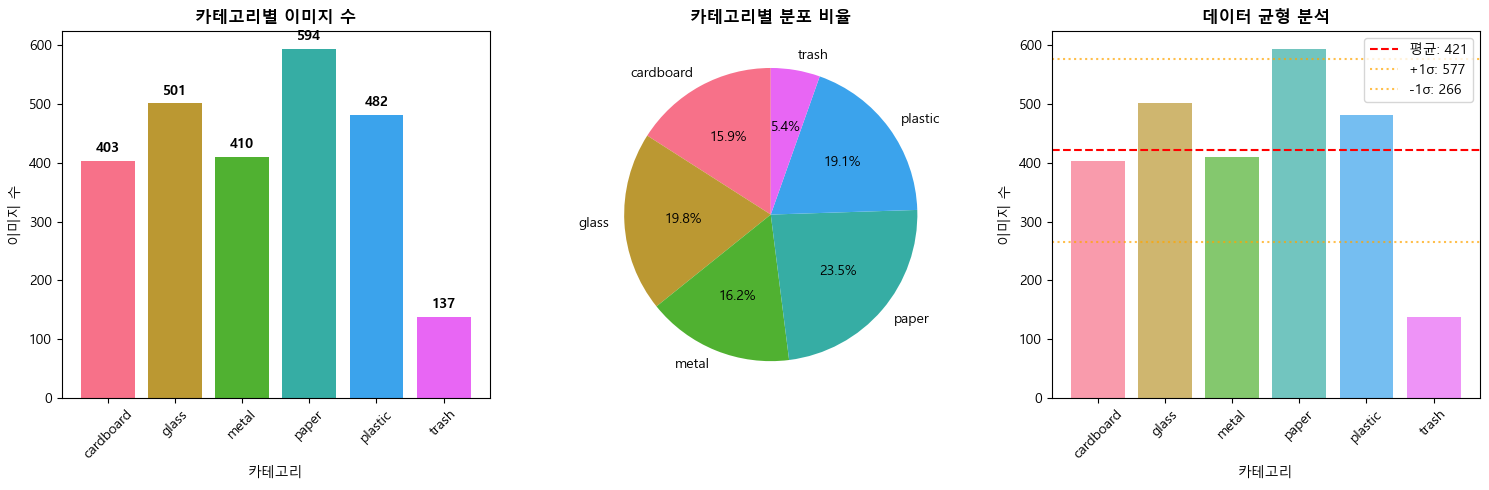

📈 데이터셋 통계:
  최대: 594개 (paper)
  최소: 137개 (trash)
  평균: 421.2개
  표준편차: 155.7
  불균형 비율: 4.34:1


In [14]:
# 📊 데이터셋 분포 시각화

if dataset_info:
    # DataFrame 생성
    df = pd.DataFrame(dataset_info)
    
    # 한글 폰트 설정
    plt.rcParams['font.family'] = 'DejaVu Sans'
    try:
        plt.rcParams['font.family'] = 'Malgun Gothic'
    except:
        try:
            plt.rcParams['font.family'] = 'AppleGothic'
        except:
            try:
                plt.rcParams['font.family'] = 'NanumGothic'
            except:
                plt.rcParams['font.family'] = 'DejaVu Sans'

    # 마이너스 기호 깨짐 방지
    plt.rcParams['axes.unicode_minus'] = False

    # 시각화
    plt.figure(figsize=(15, 5))
    
    # 1. 카테고리별 이미지 수 막대그래프
    plt.subplot(1, 3, 1)
    bars = plt.bar(df['Category'], df['Count'], color=sns.color_palette("husl", NUM_CLASSES))
    plt.title('카테고리별 이미지 수', fontsize=12, fontweight='bold')
    plt.xlabel('카테고리')
    plt.ylabel('이미지 수')
    plt.xticks(rotation=45)
    
    # 막대 위에 수치 표시
    for bar, count in zip(bars, df['Count']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                str(count), ha='center', va='bottom', fontweight='bold')
    
    # 2. 비율 파이차트
    plt.subplot(1, 3, 2)
    colors = sns.color_palette("husl", NUM_CLASSES)
    plt.pie(df['Count'], labels=df['Category'], autopct='%1.1f%%', 
            colors=colors, startangle=90)
    plt.title('카테고리별 분포 비율', fontsize=12, fontweight='bold')
    
    # 3. 데이터 불균형 확인
    plt.subplot(1, 3, 3)
    mean_count = df['Count'].mean()
    std_count = df['Count'].std()
    plt.axhline(y=mean_count, color='red', linestyle='--', label=f'평균: {mean_count:.0f}')
    plt.axhline(y=mean_count + std_count, color='orange', linestyle=':', alpha=0.7, label=f'+1σ: {mean_count + std_count:.0f}')
    plt.axhline(y=mean_count - std_count, color='orange', linestyle=':', alpha=0.7, label=f'-1σ: {mean_count - std_count:.0f}')
    
    plt.bar(df['Category'], df['Count'], color=colors, alpha=0.7)
    plt.title('데이터 균형 분석', fontsize=12, fontweight='bold')
    plt.xlabel('카테고리')
    plt.ylabel('이미지 수')
    plt.xticks(rotation=45)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 통계 요약
    print("📈 데이터셋 통계:")
    print(f"  최대: {df['Count'].max():,}개 ({df.loc[df['Count'].idxmax(), 'Category']})")
    print(f"  최소: {df['Count'].min():,}개 ({df.loc[df['Count'].idxmin(), 'Category']})")
    print(f"  평균: {df['Count'].mean():.1f}개")
    print(f"  표준편차: {df['Count'].std():.1f}")
    print(f"  불균형 비율: {df['Count'].max() / df['Count'].min():.2f}:1")


In [15]:
# 🔧 3. 데이터 전처리 함수 정의

def process_single_image(image_path):
    """단일 이미지를 처리하는 함수"""
    try:
        # 이미지 타입 확인
        kind = imghdr.what(image_path)
        if kind not in ["gif", "png", "jpeg", "jpg"]:
            return None
            
        # 이미지 로드 및 리사이즈
        img = pilimg.open(image_path)
        
        # RGB로 변환 (RGBA나 그레이스케일 이미지 처리)
        if img.mode != 'RGB':
            img = img.convert('RGB')
            
        # 크기 조정
        img_resized = img.resize(IMAGE_SIZE)
        
        # numpy 배열로 변환
        pixel_array = np.array(img_resized)
        
        # 올바른 shape 확인
        if pixel_array.shape == (*IMAGE_SIZE, CHANNELS):
            return pixel_array
        else:
            return None
            
    except Exception as e:
        print(f"이미지 처리 오류: {image_path} - {str(e)}")
        return None

def preprocess_category_data(category_name, label):
    """특정 카테고리의 모든 이미지를 전처리하는 함수"""
    category_path = os.path.join(base_path, category_name)
    
    if not os.path.exists(category_path):
        print(f"❌ 카테고리 폴더를 찾을 수 없습니다: {category_path}")
        return [], []
    
    print(f"🔄 {category_name} 카테고리 처리 중...")
    
    data = []
    labels = []
    processed_count = 0
    error_count = 0
    
    # 파일 목록 가져오기
    image_files = [f for f in os.listdir(category_path) 
                   if f.lower().endswith(('.jpg', '.jpeg', '.png', '.gif'))]
    
    total_files = len(image_files)
    
    for idx, filename in enumerate(image_files):
        if idx % 100 == 0 and idx > 0:
            print(f"  진행률: {idx}/{total_files} ({idx/total_files*100:.1f}%)")
        
        image_path = os.path.join(category_path, filename)
        processed_image = process_single_image(image_path)
        
        if processed_image is not None:
            data.append(processed_image)
            labels.append(label)
            processed_count += 1
        else:
            error_count += 1
    
    print(f"✅ {category_name} 완료: {processed_count}개 성공, {error_count}개 실패")
    
    return data, labels
def save_preprocessed_data(category_name, label, data, labels):
    """전처리된 데이터를 NPZ 파일로 저장"""
    if len(data) == 0:
        print(f"⚠️ {category_name}: 저장할 데이터가 없습니다.")
        return
    
    # NPZ 파일 저장 경로 설정
    npz_save_path = r"C:/Users/ryan9/문서/GitHub/SeSac-AI-Developer-Notes-2025/07_Deep_Learning/data/npz"
    
    # 디렉토리가 존재하지 않으면 생성
    os.makedirs(npz_save_path, exist_ok=True)
    
    filename = f"imagedata{label}_{title}.npz"
    full_path = os.path.join(npz_save_path, filename)
    
    np.savez(full_path, data=np.array(data), targets=np.array(labels))
    print(f"💾 {category_name} 데이터 저장: {full_path} ({len(data):,}개 이미지)")

print("✅ 데이터 전처리 함수 정의 완료!")


✅ 데이터 전처리 함수 정의 완료!


## ⚙️ 4. 데이터 전처리 실행

**주의:** 이 단계는 시간이 오래 걸릴 수 있습니다. 처음 한 번만 실행하세요.

아래 셀의 주석을 해제하고 실행하여 이미지 데이터를 NPZ 파일로 변환합니다.


In [16]:
# 데이터 전처리 실행 (주석 해제하여 실행)
def run_preprocessing():
    """모든 카테고리의 데이터를 전처리하는 함수"""
    if not os.path.exists(base_path):
        print("❌ 데이터 경로가 존재하지 않습니다.")
        return
    
    print("🚀 데이터 전처리 시작...")
    print("⏰ 시간이 오래 걸릴 수 있습니다. 잠시만 기다려주세요.")
    
    categories = [d for d in os.listdir(base_path) 
                  if os.path.isdir(os.path.join(base_path, d))]
    
    for idx, category in enumerate(categories):
        print(f"\n📁 [{idx+1}/{len(categories)}] {category} 처리 중...")
        
        # 카테고리별 데이터 전처리
        data, labels = preprocess_category_data(category, idx)
        
        # NPZ 파일로 저장
        save_preprocessed_data(category, idx, data, labels)
    
    print("\n🎉 모든 데이터 전처리 완료!")

# 주석을 해제하고 실행하세요 (처음 한 번만)
run_preprocessing()


🚀 데이터 전처리 시작...
⏰ 시간이 오래 걸릴 수 있습니다. 잠시만 기다려주세요.

📁 [1/6] cardboard 처리 중...
🔄 cardboard 카테고리 처리 중...
  진행률: 100/403 (24.8%)
  진행률: 200/403 (49.6%)
  진행률: 300/403 (74.4%)
  진행률: 400/403 (99.3%)
✅ cardboard 완료: 403개 성공, 0개 실패
💾 cardboard 데이터 저장: C:/Users/ryan9/문서/GitHub/SeSac-AI-Developer-Notes-2025/07_Deep_Learning/data/npz\imagedata0_thresh.npz (403개 이미지)

📁 [2/6] glass 처리 중...
🔄 glass 카테고리 처리 중...
  진행률: 100/501 (20.0%)
  진행률: 200/501 (39.9%)
  진행률: 300/501 (59.9%)
  진행률: 400/501 (79.8%)
  진행률: 500/501 (99.8%)
✅ glass 완료: 501개 성공, 0개 실패
💾 glass 데이터 저장: C:/Users/ryan9/문서/GitHub/SeSac-AI-Developer-Notes-2025/07_Deep_Learning/data/npz\imagedata1_thresh.npz (501개 이미지)

📁 [3/6] metal 처리 중...
🔄 metal 카테고리 처리 중...
  진행률: 100/410 (24.4%)
  진행률: 200/410 (48.8%)
  진행률: 300/410 (73.2%)
  진행률: 400/410 (97.6%)
✅ metal 완료: 410개 성공, 0개 실패
💾 metal 데이터 저장: C:/Users/ryan9/문서/GitHub/SeSac-AI-Developer-Notes-2025/07_Deep_Learning/data/npz\imagedata2_thresh.npz (410개 이미지)

📁 [4/6] paper 처리 중...
🔄 paper 카테고

In [17]:
# 📂 5. 데이터 로드 및 분할 함수

def load_preprocessed_data():
    """저장된 NPZ 파일들을 로드하여 학습/테스트 데이터로 분할"""
    print("📂 전처리된 데이터 로드 중...")
    
    # NPZ 파일 경로 지정
    npz_path = "C:/Users/ryan9/문서/GitHub/SeSac-AI-Developer-Notes-2025/07_Deep_Learning/data/npz"
    
    # NPZ 파일 확인
    if os.path.exists(npz_path):
        npz_files = [f for f in os.listdir(npz_path) if f.endswith('.npz')]
        npz_files = [os.path.join(npz_path, f) for f in npz_files]
    else:
        print(f"❌ 경로가 존재하지 않습니다: {npz_path}")
        return None
    
    if not npz_files:
        print(f"❌ {npz_path} 경로에서 NPZ 파일을 찾을 수 없습니다. 먼저 데이터 전처리를 실행해주세요.")
        return None
    
    print(f"🔍 발견된 NPZ 파일: {len(npz_files)}개")
    
    all_data = []
    all_labels = []
    
    # 각 NPZ 파일 로드
    for npz_file in sorted(npz_files):
        print(f"  📁 {os.path.basename(npz_file)} 로드 중...")
        data = np.load(npz_file)
        
        images = data['data']
        labels = data['targets']
        
        all_data.append(images)
        all_labels.append(labels)
        
        print(f"    └─ {len(images):,}개 이미지, 라벨: {np.unique(labels)}")
    
    # 모든 데이터 합치기
    X = np.concatenate(all_data, axis=0)
    y = np.concatenate(all_labels, axis=0)
    
    print(f"\n📊 전체 데이터:")
    print(f"  이미지: {X.shape}")
    print(f"  라벨: {y.shape}")
    print(f"  클래스별 분포: {Counter(y)}")
    
    # 학습/테스트 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    print(f"\n✅ 데이터 분할 완료:")
    print(f"  훈련 데이터: {X_train.shape} / {y_train.shape}")
    print(f"  테스트 데이터: {X_test.shape} / {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

def preprocess_for_training(X_train, X_test):
    """모델 학습을 위한 데이터 전처리"""
    print("🔧 학습용 데이터 전처리 중...")
    
    # 차원 변환: 4D(이미지) -> 2D(Dense 레이어용)
    n_features = IMAGE_SIZE[0] * IMAGE_SIZE[1] * CHANNELS
    
    X_train_flat = X_train.reshape(X_train.shape[0], n_features)
    X_test_flat = X_test.reshape(X_test.shape[0], n_features)
    
    # 정규화 (0-255 -> 0-1)
    X_train_normalized = X_train_flat.astype('float32') / 255.0
    X_test_normalized = X_test_flat.astype('float32') / 255.0
    
    # 표준화 (선택사항)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_normalized)
    X_test_scaled = scaler.transform(X_test_normalized)
    
    print(f"✅ 전처리 완료:")
    print(f"  특성 수: {n_features:,}")
    print(f"  훈련 데이터 범위: [{X_train_scaled.min():.3f}, {X_train_scaled.max():.3f}]")
    print(f"  테스트 데이터 범위: [{X_test_scaled.min():.3f}, {X_test_scaled.max():.3f}]")
    
    return X_train_scaled, X_test_scaled, scaler

print("✅ 데이터 로드 함수 정의 완료!")


✅ 데이터 로드 함수 정의 완료!


## 🤖 6. 모델 설계 및 구성


In [18]:
def create_model(input_shape):
    """딥러닝 모델 생성 함수"""
    print("🤖 신경망 모델 구성 중...")
    
    model = models.Sequential([
        # 입력층
        layers.Dense(512, activation='relu', input_shape=(input_shape,), name='dense_1'),
        layers.Dropout(0.3, name='dropout_1'),
        
        # 은닉층 1
        layers.Dense(256, activation='relu', name='dense_2'),
        layers.Dropout(0.3, name='dropout_2'),
        
        # 은닉층 2
        layers.Dense(128, activation='relu', name='dense_3'),
        layers.Dropout(0.2, name='dropout_3'),
        
        # 은닉층 3
        layers.Dense(64, activation='relu', name='dense_4'),
        layers.Dropout(0.2, name='dropout_4'),
        
        # 출력층 (6개 클래스)
        layers.Dense(NUM_CLASSES, activation='softmax', name='output')
    ])
    
    # 모델 컴파일
    model.compile(
        optimizer='adam',  # Adam 옵티마이저 사용
        loss='sparse_categorical_crossentropy',  # 다중 클래스 분류
        metrics=['accuracy']
    )
    
    print("✅ 모델 구성 완료!")
    return model

def display_model_info(model):
    """모델 정보 출력"""
    print("\n🏗️ 모델 구조:")
    model.summary()
    
    # 파라미터 수 계산
    total_params = model.count_params()
    trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    
    print(f"\n📊 모델 파라미터:")
    print(f"  전체 파라미터: {total_params:,}")
    print(f"  학습 가능한 파라미터: {trainable_params:,}")
    print(f"  모델 크기 (예상): {total_params * 4 / 1024 / 1024:.2f} MB")

print("✅ 모델 설계 함수 정의 완료!")


✅ 모델 설계 함수 정의 완료!


## 🚀 7. 데이터 로드 및 모델 학습 실행


In [19]:
# 1. 데이터 로드
print("📂 1단계: 데이터 로드")
data_result = load_preprocessed_data()

if data_result is not None:
    X_train_raw, X_test_raw, y_train, y_test = data_result
    
    # 2. 학습용 전처리
    print("\n🔧 2단계: 학습용 전처리")
    X_train_scaled, X_test_scaled, scaler = preprocess_for_training(X_train_raw, X_test_raw)
    
    # 3. 모델 생성
    print("\n🤖 3단계: 모델 생성")
    input_features = X_train_scaled.shape[1]
    model = create_model(input_features)
    display_model_info(model)
    
    print(f"\n📊 최종 데이터 형태:")
    print(f"  X_train: {X_train_scaled.shape}")
    print(f"  X_test: {X_test_scaled.shape}")
    print(f"  y_train: {y_train.shape} (클래스: {np.unique(y_train)})")
    print(f"  y_test: {y_test.shape} (클래스: {np.unique(y_test)})")
    
else:
    print("❌ 데이터 로드 실패. 먼저 데이터 전처리를 실행해주세요.")


📂 1단계: 데이터 로드
📂 전처리된 데이터 로드 중...
🔍 발견된 NPZ 파일: 10개
  📁 imagedata0_test.npz 로드 중...
    └─ 77개 이미지, 라벨: [0]
  📁 imagedata0_thresh.npz 로드 중...
    └─ 403개 이미지, 라벨: [0]
  📁 imagedata0_train.npz 로드 중...
    └─ 529개 이미지, 라벨: [0]
  📁 imagedata1_test.npz 로드 중...
    └─ 105개 이미지, 라벨: [1]
  📁 imagedata1_thresh.npz 로드 중...
    └─ 501개 이미지, 라벨: [1]
  📁 imagedata1_train.npz 로드 중...
    └─ 746개 이미지, 라벨: [1]
  📁 imagedata2_thresh.npz 로드 중...
    └─ 410개 이미지, 라벨: [2]
  📁 imagedata3_thresh.npz 로드 중...
    └─ 594개 이미지, 라벨: [3]
  📁 imagedata4_thresh.npz 로드 중...
    └─ 482개 이미지, 라벨: [4]
  📁 imagedata5_thresh.npz 로드 중...
    └─ 137개 이미지, 라벨: [5]

📊 전체 데이터:
  이미지: (3984, 80, 80, 3)
  라벨: (3984,)
  클래스별 분포: Counter({np.int64(1): 1352, np.int64(0): 1009, np.int64(3): 594, np.int64(4): 482, np.int64(2): 410, np.int64(5): 137})

✅ 데이터 분할 완료:
  훈련 데이터: (2788, 80, 80, 3) / (2788,)
  테스트 데이터: (1196, 80, 80, 3) / (1196,)

🔧 2단계: 학습용 전처리
🔧 학습용 데이터 전처리 중...
✅ 전처리 완료:
  특성 수: 19,200
  훈련 데이터 범위: [-2.717, 2.454]
  테스트

c:\Users\ryan9\miniconda3\envs\sesac_ai\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 512)            │     9,830,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,003,782 (38.16 MB)

 Trainable params: 10,003,782 (38.16 MB)

 Non-trainable params: 0 (0.00 B)


📊 모델 파라미터:
  전체 파라미터: 10,003,782
  학습 가능한 파라미터: 10,003,782
  모델 크기 (예상): 38.16 MB

📊 최종 데이터 형태:
  X_train: (2788, 19200)
  X_test: (1196, 19200)
  y_train: (2788,) (클래스: [0 1 2 3 4 5])
  y_test: (1196,) (클래스: [0 1 2 3 4 5])


## 📈 8. 모델 학습


In [20]:
# 모델 학습 실행
if 'model' in locals() and 'X_train_scaled' in locals():
    print("🚀 모델 학습 시작...")
    
    # 콜백 설정
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    # 학습 실행
    print("⏰ 학습 중... (시간이 소요될 수 있습니다)")
    history = model.fit(
        X_train_scaled, y_train,
        epochs=30,
        batch_size=64,
        validation_split=0.2,
        callbacks=callbacks,
        verbose=1
    )
    
    print("\n🎉 학습 완료!")
    
else:
    print("❌ 먼저 이전 셀을 실행하여 데이터를 로드하고 모델을 생성해주세요.")


🚀 모델 학습 시작...
⏰ 학습 중... (시간이 소요될 수 있습니다)
Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.2976 - loss: 6.5043 - val_accuracy: 0.3835 - val_loss: 2.0157 - learning_rate: 0.0010
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.3197 - loss: 3.4265 - val_accuracy: 0.3566 - val_loss: 1.4173 - learning_rate: 0.0010
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.3342 - loss: 1.9811 - val_accuracy: 0.4194 - val_loss: 1.3838 - learning_rate: 0.0010
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.3557 - loss: 1.7247 - val_accuracy: 0.3781 - val_loss: 1.3988 - learning_rate: 0.0010
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.3735 - loss: 1.5572 - val_accuracy: 0.3907 - val_loss: 1.3447 - learning_rate: 0.0010
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.3783 - loss: 1.4507 - val_accuracy: 0.3907 - val_loss: 1.3511 - learning_rate: 0.0010
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - 

## 📊 9. 모델 평가 및 결과 분석


📊 모델 성능 평가:
  📈 훈련 성능: 손실 0.8404, 정확도 0.6485 (64.8%)
  📊 테스트 성능: 손실 1.0772, 정확도 0.5493 (54.9%)
  🔍 과적합 여부: 양호


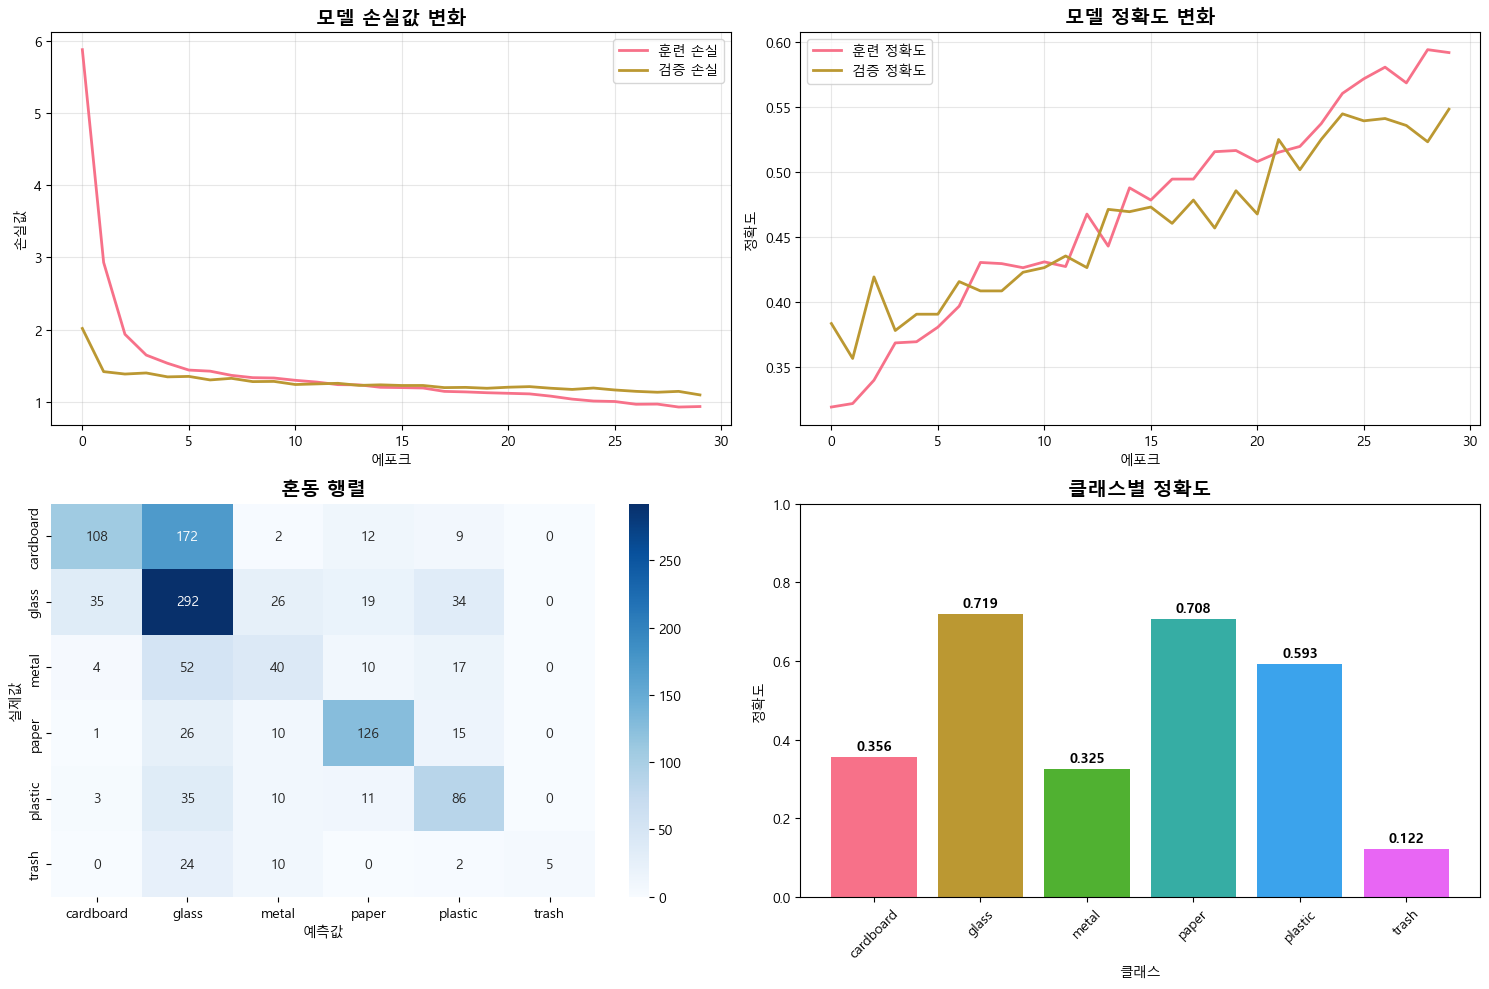


📋 상세 분류 리포트:
              precision    recall  f1-score   support

   cardboard       0.72      0.36      0.48       303
       glass       0.49      0.72      0.58       406
       metal       0.41      0.33      0.36       123
       paper       0.71      0.71      0.71       178
     plastic       0.53      0.59      0.56       145
       trash       1.00      0.12      0.22        41

    accuracy                           0.55      1196
   macro avg       0.64      0.47      0.48      1196
weighted avg       0.59      0.55      0.54      1196



In [22]:
# 모델 평가 및 시각화
if 'history' in locals() and 'model' in locals():
    
    # 1. 모델 성능 평가
    print("📊 모델 성능 평가:")
    train_loss, train_acc = model.evaluate(X_train_scaled, y_train, verbose=0)
    test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
    
    print(f"  📈 훈련 성능: 손실 {train_loss:.4f}, 정확도 {train_acc:.4f} ({train_acc*100:.1f}%)")
    print(f"  📊 테스트 성능: 손실 {test_loss:.4f}, 정확도 {test_acc:.4f} ({test_acc*100:.1f}%)")
    print(f"  🔍 과적합 여부: {'과적합 의심' if (train_acc - test_acc) > 0.1 else '양호'}")
    
    # 2. 학습 과정 시각화
    plt.figure(figsize=(15, 10))
    
    # 손실값 그래프
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='훈련 손실', linewidth=2)
    plt.plot(history.history['val_loss'], label='검증 손실', linewidth=2)
    plt.title('모델 손실값 변화', fontsize=14, fontweight='bold')
    plt.xlabel('에포크')
    plt.ylabel('손실값')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 정확도 그래프
    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='훈련 정확도', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='검증 정확도', linewidth=2)
    plt.title('모델 정확도 변화', fontsize=14, fontweight='bold')
    plt.xlabel('에포크')
    plt.ylabel('정확도')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. 예측 및 혼동 행렬
    y_pred = model.predict(X_test_scaled, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # 혼동 행렬
    cm = confusion_matrix(y_test, y_pred_classes)
    
    plt.subplot(2, 2, 3)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title('혼동 행렬', fontsize=14, fontweight='bold')
    plt.xlabel('예측값')
    plt.ylabel('실제값')
    
    # 4. 클래스별 정확도
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    
    plt.subplot(2, 2, 4)
    bars = plt.bar(CLASS_NAMES, class_accuracy, color=sns.color_palette("husl", NUM_CLASSES))
    plt.title('클래스별 정확도', fontsize=14, fontweight='bold')
    plt.xlabel('클래스')
    plt.ylabel('정확도')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    
    # 막대 위에 수치 표시
    for bar, acc in zip(bars, class_accuracy):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 5. 상세 분류 리포트
    print("\n📋 상세 분류 리포트:")
    print(classification_report(y_test, y_pred_classes, target_names=CLASS_NAMES))
    
else:
    print("❌ 먼저 모델 학습을 완료해주세요.")


## 🔮 10. 예측 테스트 및 샘플 분석


In [24]:
# 예측 테스트 및 샘플 분석
if 'model' in locals() and 'X_test_scaled' in locals():
    
    # 랜덤 샘플 선택
    np.random.seed(42)
    sample_indices = np.random.choice(len(X_test_scaled), 15, replace=False)
    
    # 예측 수행
    sample_predictions = model.predict(X_test_scaled[sample_indices], verbose=0)
    sample_pred_classes = np.argmax(sample_predictions, axis=1)
    sample_true_classes = y_test[sample_indices]
    
    print("🔮 예측 결과 분석 (15개 샘플):")
    print("=" * 60)
    
    correct_count = 0
    for i in range(15):
        true_class = CLASS_NAMES[sample_true_classes[i]]
        pred_class = CLASS_NAMES[sample_pred_classes[i]]
        confidence = np.max(sample_predictions[i]) * 100
        is_correct = sample_true_classes[i] == sample_pred_classes[i]
        
        if is_correct:
            correct_count += 1
            status = "✅ 정답"
            emoji = "🎯"
        else:
            status = "❌ 오답"
            emoji = "💥"
        
        print(f"{emoji} 샘플 {i+1:2d}: {true_class:9} → {pred_class:9} ({confidence:5.1f}%) {status}")
    
    print("=" * 60)
    print(f"📊 샘플 정확도: {correct_count}/15 ({correct_count/15*100:.1f}%)")
    
    # 신뢰도 분석
    print(f"\n🔍 신뢰도 분석:")
    all_predictions = model.predict(X_test_scaled, verbose=0)
    all_confidences = np.max(all_predictions, axis=1)
    
    print(f"  평균 신뢰도: {np.mean(all_confidences):.3f}")
    print(f"  신뢰도 범위: {np.min(all_confidences):.3f} ~ {np.max(all_confidences):.3f}")
    print(f"  높은 신뢰도 (>0.9): {np.sum(all_confidences > 0.9)} / {len(all_confidences)} ({np.sum(all_confidences > 0.9)/len(all_confidences)*100:.1f}%)")
    print(f"  낮은 신뢰도 (<0.6): {np.sum(all_confidences < 0.6)} / {len(all_confidences)} ({np.sum(all_confidences < 0.6)/len(all_confidences)*100:.1f}%)")
    
    # 모델 저장 (선택사항)
    print(f"\n💾 모델 저장:")
    import os
    model_dir = r"C:\Users\ryan9\문서\GitHub\SeSac-AI-Developer-Notes-2025\07_Deep_Learning\data\models"
    os.makedirs(model_dir, exist_ok=True)
    model_filename = f"garbage_classifier_model_{NUM_CLASSES}classes.h5"
    model_path = os.path.join(model_dir, model_filename)
    model.save(model_path)
    print(f"  모델 저장됨: {model_path}")
    
    print(f"\n🎉 쓰레기 분류 모델 완성!")
    print(f"  📊 최종 테스트 정확도: {test_acc:.4f} ({test_acc*100:.1f}%)")
    print(f"  🎯 분류 가능한 카테고리: {', '.join(CLASS_NAMES)}")
    
else:
    print("❌ 먼저 모델 학습과 평가를 완료해주세요.")


🔮 예측 결과 분석 (15개 샘플):
🎯 샘플  1: paper     → paper     ( 54.2%) ✅ 정답
💥 샘플  2: cardboard → glass     ( 56.7%) ❌ 오답
🎯 샘플  3: glass     → glass     ( 66.6%) ✅ 정답
💥 샘플  4: glass     → metal     ( 57.3%) ❌ 오답
🎯 샘플  5: glass     → glass     ( 57.4%) ✅ 정답
💥 샘플  6: metal     → glass     ( 19.6%) ❌ 오답
💥 샘플  7: paper     → glass     ( 21.1%) ❌ 오답
💥 샘플  8: cardboard → glass     ( 55.4%) ❌ 오답
🎯 샘플  9: plastic   → plastic   ( 81.5%) ✅ 정답
💥 샘플 10: cardboard → glass     ( 58.4%) ❌ 오답
🎯 샘플 11: cardboard → cardboard ( 56.4%) ✅ 정답
💥 샘플 12: cardboard → glass     ( 25.8%) ❌ 오답
🎯 샘플 13: paper     → paper     (100.0%) ✅ 정답
💥 샘플 14: glass     → plastic   ( 65.0%) ❌ 오답
🎯 샘플 15: paper     → paper     ( 67.1%) ✅ 정답
📊 샘플 정확도: 7/15 (46.7%)

🔍 신뢰도 분석:


  평균 신뢰도: 0.546
  신뢰도 범위: 0.180 ~ 1.000
  높은 신뢰도 (>0.9): 93 / 1196 (7.8%)
  낮은 신뢰도 (<0.6): 751 / 1196 (62.8%)

💾 모델 저장:
  모델 저장됨: C:\Users\ryan9\문서\GitHub\SeSac-AI-Developer-Notes-2025\07_Deep_Learning\data\models\garbage_classifier_model_6classes.h5

🎉 쓰레기 분류 모델 완성!
  📊 최종 테스트 정확도: 0.5493 (54.9%)
  🎯 분류 가능한 카테고리: cardboard, glass, metal, paper, plastic, trash
